# Flowbile: Data Description
## Imports and Settings

In [1]:
%matplotlib inline

In [2]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import collections
import numpy as np
import datetime
import matplotlib.dates as mdates

In [3]:
warnings.filterwarnings('ignore')

In [4]:
color_full = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
color_pale = ['#7f7f7f', '#f18c8d', '#9bbedb', '#a6d7a4', '#cba6d1', '#ffbf7f', '#ffff99', '#d2aa93', '#fbc0df', '#cccccc']

## Helper Functions
Get probability distribution function (PDF) given list:

In [5]:
def pdf(l):
    counter = collections.Counter(l)
    a = np.column_stack((list(counter.keys()), list(counter.values())))
    a = np.column_stack((a, a[:, 1]/sum(a[:, 1])))
    a = a[a[: ,0].argsort()]
    return a

Get binned probability distribution function given PDF:

In [6]:
def pdf_bin(a, bins):
    decades = np.ceil(np.log10(max(a[:, 0])-min(a[:, 0])))
    bin_min = np.log10(min(a[:, 0]))
    a_bin = np.full((bins, 3), np.nan)
    for i in range(0, bins):
        b = a[(a[:, 0] >= round(10**(bin_min+i*decades/bins))) & (a[:, 0] < round(10**(bin_min+(i+1)*decades/bins)))]
        if len(b)>0:
            a_bin[i, 0] = np.mean(b[:, 0])
            a_bin[i, 1] = sum(b[:, 1])
            a_bin[i, 2] = round(10**(bin_min+(i+1)*decades/bins))-round(10**(bin_min+i*decades/bins))
    a_bin = a_bin[~np.isnan(a_bin[:, 0])]
    a_bin = np.column_stack((a_bin, (a_bin[:, 1]/sum(a[:, 1]))/a_bin[:, 2]))
    return a_bin

Plot probability distribution function:

In [7]:
def plot_pdf(l, xlabel, title, binning=True, scaling=True):
    a = pdf(l)
    a_bin = pdf_bin(a, bins=20)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    if binning == False:
        ax.plot(a[:, 0], a[:, 2], marker='o', markersize=12, ls='', color=color_full[0], label='')
    else:
        ax.plot(a_bin[:, 0], a_bin[:, 3], marker='o', markersize=12, color=color_full[0], ls='', label='')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    if scaling == True:
        ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(title, fontsize=24)
    ax.set_xlabel(xlabel, fontsize=24)
    ax.set_ylabel('$p($' + xlabel + '$)$', fontsize=24)
    ax.tick_params(axis="x", which='major', direction="in", width=2, size=4*2, labelsize=24, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=2, size=2*2, labelsize=24, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=2, size=4*2, labelsize=24)
    ax.tick_params(axis="y", which='minor', direction="in", width=2, size=2*2, labelsize=24)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.legend(fontsize=18)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.15, top=0.85)

## Data Model
Data generated by users $u$ is modeled as a network with resting points $v$ as nodes and ways $e$ as directed edges. Chains of ways amount to tracks $f$. Tracks originate and terminate at resting points where a user rests for at least 30 minutes ("große Ruhe". Resting points where users rest for less than 30 minutes ("kleine Ruhe") connect ways into tracks.

## Data Description
### Load Data

In [8]:
ways_summary = pd.read_csv('../data/ways_summary.csv', delimiter = ';')

In [9]:
ways_summary.head()

,id,track_id,user_id,stat_group,series,time_begin,time_end,type,start_location,end_location,distance,distance_sum,speed,speed_avg,prev_rp,next_rp,path
0,1,3,2,1,1,2015-11-04 10:12:28,2015-11-04 11:06:35,foot,Stadt Mittweida,Stadt Mittweida,572.94,1145.87,0.64,0.64,50296654,50296655,"LINESTRING(12.97399 50.986117,12.97399 50.9861..."
1,2,3,2,1,1,2015-11-04 11:06:35,2015-11-04 11:06:43,car,Stadt Mittweida,Stadt Mittweida,218.09,1582.05,785.12,392.88,50296655,50296656,"LINESTRING(12.973538 50.987706,12.972125 50.98..."
2,1,15,3,1,1,2015-11-04 12:12:17,2015-11-04 12:16:05,foot,Stadt Mittweida,Stadt Mittweida,358.66,717.31,5.66,5.66,None,50296701,"LINESTRING(12.972569 50.986345,12.972569 50.98..."
3,1,20,3,1,1,2015-11-04 12:56:46,2015-11-04 12:57:59,foot,Stadt Mittweida,Stadt Mittweida,52.57,105.14,2.59,2.59,50296701,50296702,"LINESTRING(12.970304 50.986862,12.970304 50.98..."
4,2,20,3,1,1,2015-11-04 12:57:59,2015-11-04 13:11:34,foot,Stadt Mittweida,Stadt Mittweida,411.81,928.77,1.95,2.27,50296702,50296703,"LINESTRING(12.970304 50.986862,12.970304 50.98..."


In [10]:
resting_particles = pd.read_csv('../data/resting_particles.csv', delimiter = ';')

In [11]:
resting_particles.tail()

,id,type,user_id,stat_group,lon_begin,lat_begin,lon_end,lat_end,time_begin,time_end,prev_mp,next_mp,location
26766,26767,large,15,1,12.970666,50.985796,12.929759,50.839465,2015-12-07 13:57:33.000000,2015-12-07 15:48:11.000000,633564,633565,"[{""parking"": ""Lidl-/Takko Fashion-Parkplatz"", ..."
26767,26768,large,32,1,12.970553,50.987969,12.970888,50.987548,2016-02-16 10:08:29.000000,2016-02-16 11:58:36.000000,638497,638502,"[{""college"": ""Grunert de Jacom\u00e9-Bau (Haus..."
26768,26769,large,34,1,12.968959,50.984645,12.970838,50.985897,2016-11-28 16:08:14.000000,2016-11-28 17:00:20.000000,670639,670670,"[{""house_number"": ""52"", ""road"": ""Heinrich-Hein..."
26769,26770,large,15,1,12.924123,50.840834,12.935522,50.850587,2015-12-07 15:49:29.000000,2015-12-08 07:08:52.000000,633567,633603,"[{""house_number"": ""20"", ""road"": ""Georgstra\u00..."
26770,26771,large,32,1,12.970607,50.985512,12.970639,50.986326,2016-02-16 12:02:49.000000,2016-02-16 17:02:22.000000,638503,638541,"[{""college"": ""Zentrum f\u00fcr Medien und Sozi..."


In [12]:
resting_particles['location'][0]

'[{"house_number": "46", "road": "An der Bahnstrecke", "suburb": "Gl\\u00f6sa-Draisdorf", "city": "Chemnitz", "county": "Chemnitz", "state": "Sachsen", "postcode": "09114", "country": "Deutschland", "country_code": "de", "type": "way"}, {"post_box": "Deutsche Post", "road": "Stra\\u00dfe der Nationen", "suburb": "Zentrum", "city": "Chemnitz", "county": "Chemnitz", "state": "Sachsen", "postcode": "09111", "country": "Deutschland", "country_code": "de", "type": "node"}]'

### Start Locations

In [13]:
start_location = ways_summary.groupby('start_location').size().sort_values(ascending=False)
start_location.head()

start_location
Stadt Mittweida    14077
Stadt Chemnitz      9341
Stadt Leipzig        655
Lichtenau            256
Stadt Burgstädt      194
dtype: int64

### End Locations

In [14]:
end_location = ways_summary.groupby('end_location').size().sort_values(ascending=False)
end_location.head()

end_location
Stadt Mittweida    13754
Stadt Chemnitz      9737
Stadt Leipzig        592
Lichtenau            227
Stadt Burgstädt      139
dtype: int64

### Days

In [15]:
ways_summary['time_begin_day'] = ways_summary['time_begin'].str[:11]
time_begin_day = ways_summary.groupby('time_begin_day').size().sort_index()
time_begin_day = pd.concat([pd.Series(time_begin_day.index.tolist()), pd.Series(time_begin_day.tolist())], axis=1)
time_begin_day.columns = ['time_begin_day', 'frequency']
time_begin_day['time_begin_day'] = pd.to_datetime(time_begin_day['time_begin_day'])

In [16]:
days_delta = (max(time_begin_day['time_begin_day'])-min(time_begin_day['time_begin_day'])).days
days_list = [min(time_begin_day['time_begin_day'])+datetime.timedelta(days=x) for x in range(0, days_delta+1)]
days_list = pd.DataFrame(days_list, columns=['time_begin_day'])

In [17]:
days = pd.merge(left=time_begin_day, right=days_list, how='right', on='time_begin_day').sort_values('time_begin_day').reset_index(drop=True)

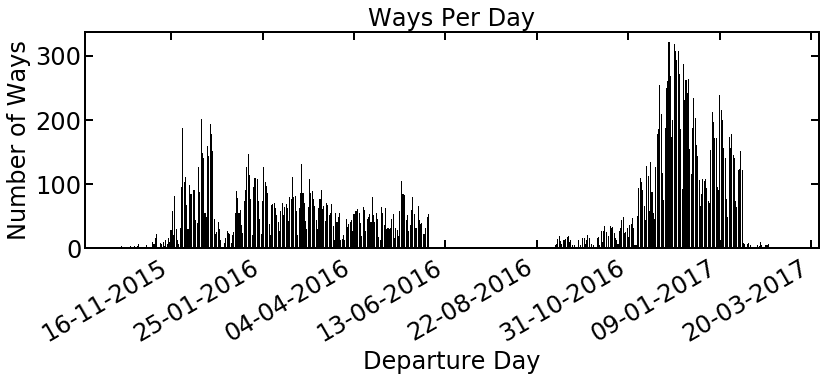

In [18]:
# https://stackoverflow.com/questions/17452179/not-write-out-all-dates-on-an-axis-matplotlib
fig = plt.figure(figsize=(12, 6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=70))
days_dt = [x.to_pydatetime() for x in list(days['time_begin_day'])]
plt.bar(days_dt, days['frequency'], align='center', color=color_full[0])
plt.gcf().autofmt_xdate()
ax = fig.add_subplot(111)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_title('Ways Per Day', fontsize=24)
ax.set_xlabel('Departure Day', fontsize=24)
ax.set_ylabel('Number of Ways', fontsize=24)
ax.tick_params(axis="x", which='major', direction="in", width=2, size=4*2, labelsize=24, pad=7)
ax.tick_params(axis="x", which='minor', direction="in", width=2, size=2*2, labelsize=24, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=2, size=4*2, labelsize=24)
ax.tick_params(axis="y", which='minor', direction="in", width=2, size=2*2, labelsize=24)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.legend(fontsize=18)
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.35, top=0.85)
#plt.savefig('WaysPerDay.pdf')

### Hours

In [19]:
ways_summary['time_begin_hour'] = ways_summary['time_begin'].str[11:13]
time_begin_hour = ways_summary.groupby('time_begin_hour').size().sort_index()
time_begin_hour = pd.concat([pd.Series(time_begin_hour.index.tolist()), pd.Series(time_begin_hour.tolist())], axis=1)
time_begin_hour.columns = ['time_begin_hour', 'frequency']

In [20]:
time_begin_hour.head()

,time_begin_hour,frequency
0,00,310
1,01,205
2,02,155
3,03,120
4,04,126


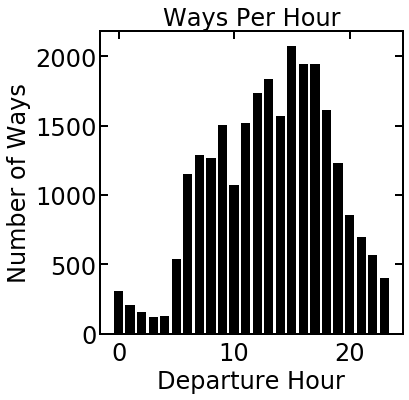

In [21]:
# https://stackoverflow.com/questions/17452179/not-write-out-all-dates-on-an-axis-matplotlib
fig = plt.figure(figsize=(6, 6))
hours = [x for x in range(0, 24)]
plt.bar(hours, time_begin_hour['frequency'], align='center', color=color_full[0])
ax = fig.add_subplot(111)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_title('Ways Per Hour', fontsize=24)
ax.set_xlabel('Departure Hour', fontsize=24)
ax.set_ylabel('Number of Ways', fontsize=24)
ax.tick_params(axis="x", which='major', direction="in", width=2, size=4*2, labelsize=24, pad=7)
ax.tick_params(axis="x", which='minor', direction="in", width=2, size=2*2, labelsize=24, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=2, size=4*2, labelsize=24)
ax.tick_params(axis="y", which='minor', direction="in", width=2, size=2*2, labelsize=24)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.legend(fontsize=18)
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.15, top=0.85)
#plt.savefig('WaysPerHour.pdf')

### Number of Ways

In [22]:
e = len(ways_summary)
e

25752

### Number of Tracks

In [23]:
f = len(set(ways_summary['track_id']))
f

14925

### Number of Users

In [24]:
u = len(set(ways_summary['user_id']))
u

164

### Number of Ways Per User

In [25]:
epu = ways_summary.groupby('user_id').size().tolist()

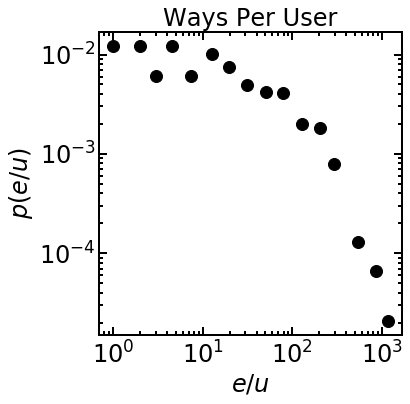

In [26]:
plot_pdf(l=epu, xlabel='$e/u$', title='Ways Per User')
#plt.savefig('WaysPerUser.pdf')

### Average Number of Ways Per User

In [27]:
round(e/u, 1)

157.0

### Number of Tracks Per User

In [28]:
ways_summary_ways = ways_summary[['track_id', 'user_id']].drop_duplicates()

In [29]:
fpu = ways_summary_ways.groupby('user_id').size().tolist()

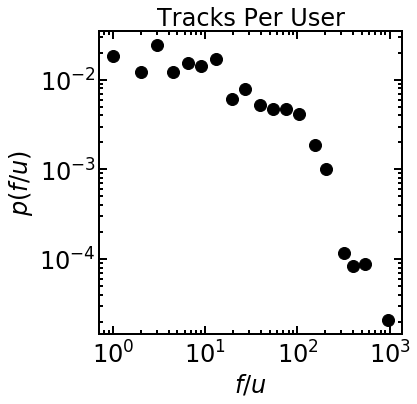

In [30]:
plot_pdf(l=fpu, xlabel='$f/u$', title='Tracks Per User')
#plt.savefig('TracksPerUser.pdf')

### Average Number of Tracks Per User

In [31]:
round(f/u, 1)

91.0

### Number of Ways Per Track

In [32]:
epf = ways_summary.groupby('track_id').size().tolist()

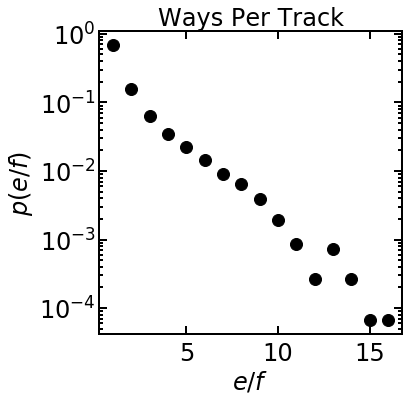

In [33]:
plot_pdf(l=epf, xlabel='$e/f$', title='Ways Per Track', binning=False, scaling=False)
#plt.savefig('WaysPerTrack.pdf')